In [ ]:
import pandas as pd

df1 = pd.read_excel('f_029df.xlsx')
df2 = pd.read_excel('f_9218df.xlsx')
df3 = pd.read_excel('f_18224df.xlsx')


In [ ]:
df1.head()

,Unnamed: 0,Unnamed: 0.1,dong,X,Y,highway,ffnc,ffc,nfnc,nfc,fsnc,fsc,nsnc,nsc,총생활인구수,affnc,affc,anfnc,anfc,afsnc,afsc,ansnc,ansc
0,0,0,가락1동,127.108235,37.495329,0.0,0.225806,0.000000,0.00,0.0,0.164634,0.000000,0.02,0.000000,0.322362,0.077419,0.000000,0.00,0.000000,0.047561,0.022764,0.012,0.034783
1,1,1,가락2동,127.130643,37.495860,0.0,0.161290,0.166667,0.00,0.0,0.024390,0.016260,0.08,0.000000,0.320622,0.038710,0.033333,0.01,0.033333,0.056098,0.043902,0.064,0.130435
2,2,2,가락본동,127.121640,37.497217,0.0,0.032258,0.000000,0.00,0.0,0.146341,0.154472,0.04,0.260870,0.445918,0.045161,0.033333,0.01,0.033333,0.040244,0.040650,0.064,0.078261
3,3,3,가리봉동,126.888257,37.482555,0.0,0.032258,0.000000,0.05,0.0,0.006098,0.000000,0.74,0.000000,0.108998,0.283871,0.000000,0.08,0.233333,0.293902,0.034146,0.392,0.234783
4,4,4,가산동,126.884341,37.476835,0.0,1.000000,0.000000,0.20,1.0,1.000000,0.065041,0.86,0.913043,0.562965,0.335484,0.000000,0.12,0.233333,0.343902,0.058537,0.408,0.286957


In [ ]:
# 필요없는 column 삭제
df1 = df1.drop('Unnamed: 0', axis = 1)
df1 = df1.drop('Unnamed: 0.1', axis = 1)
df1 = df1.drop('X', axis = 1)
df1 = df1.drop('Y', axis = 1)

df2 = df2.drop('Unnamed: 0', axis = 1)
df2 = df2.drop('Unnamed: 0.1', axis = 1)
df2 = df2.drop('X', axis = 1)
df2 = df2.drop('Y', axis = 1)

df3 = df3.drop('Unnamed: 0', axis = 1)
df3 = df3.drop('Unnamed: 0.1', axis = 1)
df3 = df3.drop('X', axis = 1)
df3 = df3.drop('Y', axis = 1)

In [ ]:
# 0 to 9시 데이터와 18시 to 24시 데이터의 총생활인구수를 평균내준 값을 기존의 총생활인구 column과 교체해줍니다.
# populaton column이 마지막에 오면 보기 수월합니다.
df1['population'] = (df1['총생활인구수'] + df3['총생활인구수'])/2

In [ ]:

df1 = df1.drop('총생활인구수', axis = 1)

In [ ]:
df1.head()

,dong,highway,ffnc,ffc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,affc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population
0,가락1동,0.0,0.225806,0.000000,0.00,0.0,0.164634,0.000000,0.02,0.000000,0.077419,0.000000,0.00,0.000000,0.047561,0.022764,0.012,0.034783,0.299870
1,가락2동,0.0,0.161290,0.166667,0.00,0.0,0.024390,0.016260,0.08,0.000000,0.038710,0.033333,0.01,0.033333,0.056098,0.043902,0.064,0.130435,0.303859
2,가락본동,0.0,0.032258,0.000000,0.00,0.0,0.146341,0.154472,0.04,0.260870,0.045161,0.033333,0.01,0.033333,0.040244,0.040650,0.064,0.078261,0.426756
3,가리봉동,0.0,0.032258,0.000000,0.05,0.0,0.006098,0.000000,0.74,0.000000,0.283871,0.000000,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.105551
4,가산동,0.0,1.000000,0.000000,0.20,1.0,1.000000,0.065041,0.86,0.913043,0.335484,0.000000,0.12,0.233333,0.343902,0.058537,0.408,0.286957,0.549815


In [ ]:
# 전에 heatmap을 그린것을 보면 ffc는 데이터가 너무 없어서 -값 내지는 매우 작은값을 보였습니다.
# 머신러닝돌릴때는 ffc와 affc도 drop합시다.
df1 = df1.drop('ffc', axis = 1)
df1 = df1.drop('affc', axis = 1)

In [ ]:
df1 = df1.drop(columns=['nfnc','nfc','nsnc','nsc','anfnc','anfc','ansnc','ansc'])

In [ ]:
# null값을 0으로 채워둡니다.
df1 = df1.fillna(0)

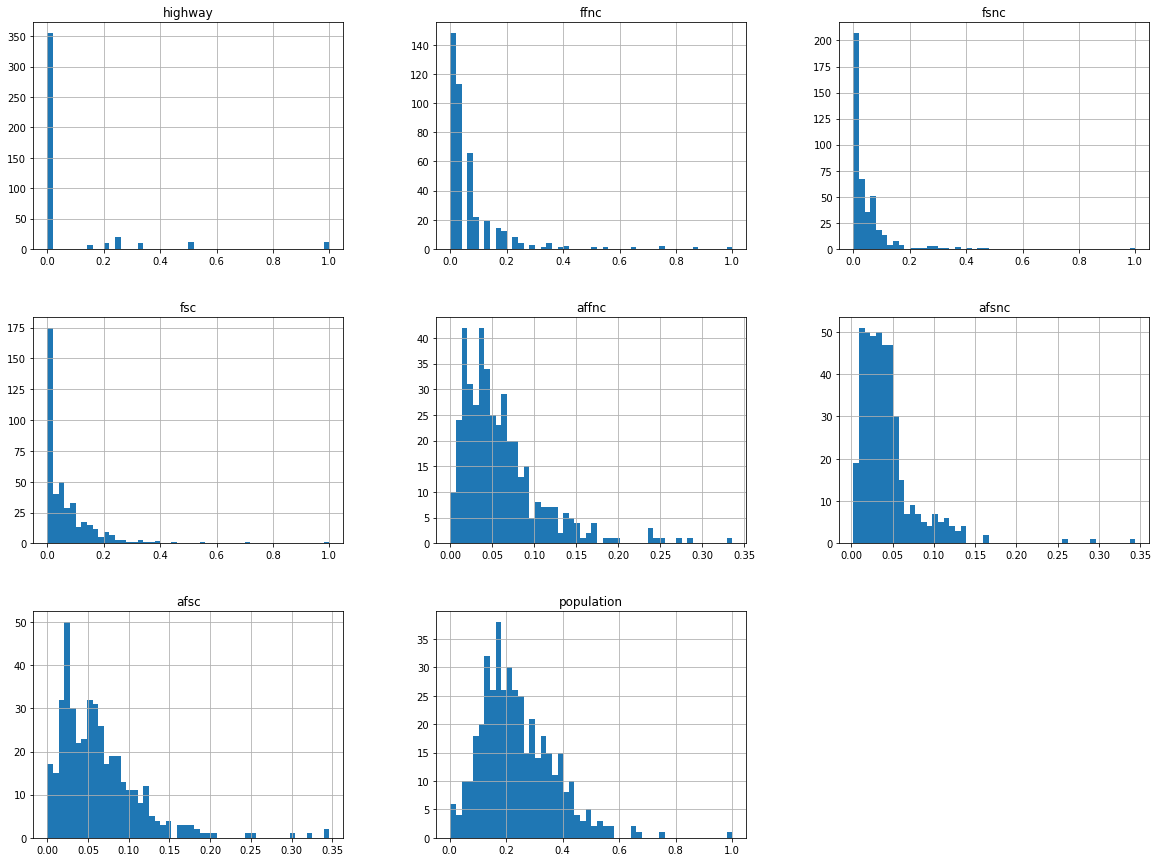

In [ ]:
# 데이터들의 histgram을 봅시다.
import matplotlib.pyplot as plt
df1.hist(bins = 50, figsize = (20,15))
plt.show()

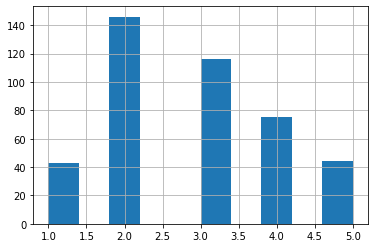

In [ ]:
# population 데이터가 class값으로 들어가게 될것입니다.
# 우리는 population data를 치우치지 않게 여러 set 뽑아주는 StratifiedKFold를 하고 싶습니다.
# population을 5개의 구역으로 나눠줬습니다. kfold를 할때 각 구역에서 일정한 값들이 뽑히게 할것입니다.

# pd.cut을 이용하여 population을 5개의 구역으로 나눈것을 pop_cut이라는 column에 담았습니다,
df1["pop_cat"] = pd.cut(df1["population"],
                              bins = [0.0, 0.1, 0.2, 0.3, 0.4, 1.0],
                              labels = [1.0, 2.0, 3.0, 4.0, 5.0])
df1["pop_cat"].hist()

In [ ]:
# average, standard deviation
import numpy as np
a = [1,3,5,7,9]
b = sum(a)/5
c = b*np.ones(5)
d = np.sqrt(sum((a - c)**2)/5)
print(b)
print(d)

5.0
2.8284271247461903


In [ ]:
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

# seed를 정해줍니다.
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

data = df1.values
x = data[:,1:-2].astype(float)  # feature
y = data[:,-2].astype(float)   # population
y_cat = data[:,-1].astype(float) # pop_cut

#  StratifiedKFold
n_fold = 5
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)
  
# 에러를 담기위해 먼저 빈 array를 만들었습니다.  
test_error_set = []  
train_error_set = [] 

# valiation loss가 patience만큼 반복해도 변하지 않거나 나빠지면 학습을 중단하게 설정합니다.  
# patience 조정가능!
ESC = EarlyStopping(monitor = 'val_loss', patience = 10) 

for train, test in skf.split(x,y_cat): # StratifiedKFold로 나눈 데이터 셋을 받습니다. n_fold가 5이므로 for문은 5번 돌것입니다.
  model = Sequential()
  model.add(Dense(7,input_dim = 7, activation= 'relu'))
  model.add(Dense(1,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])
  # fold별로 error를 받아줘서 위에 만든 빈 array에 담아줍니다.
  train_error = mean_squared_error(y[train], model.predict(x[train])) 
  test_error = mean_squared_error(y[test], model.predict(x[test]))
  train_error_set.append(train_error)
  test_error_set.append(test_error)
# error들의 평균과 표준편차를 구해줍니다.
average_train_error = sum(train_error_set)/5
ate1 = average_train_error*np.ones(5)
train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
average_test_error = sum(test_error_set)/5
ate2 = average_test_error*np.ones(5)
test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

print('train:',average_train_error,train_standard_deviation)
print('test:',average_test_error,test_standard_deviation)



Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0746 - val_loss: 0.0595
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0593 - val_loss: 0.0493
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0415
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.0351
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0301
Epoch 6/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0267
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0218
Epoch 9/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0204
Epoch 10/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 11/

In [ ]:
# 위에서 만든 모델을 바탕으로 layer 수와 node 갯수를 변수로 받는 함수를 만들어줍니다.

def construct_layer(layer_num,node_num):
  test_error_set = []  
  train_error_set = []  
  
  for train, test in skf.split(x,y_cat):
    model = Sequential()
    model.add(Dense(node_num,input_dim = 7, activation= 'relu'))
    model.add(Dense(layer_num,activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
    model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])
    train_error = mean_squared_error(y[train], model.predict(x[train]))
    test_error = mean_squared_error(y[test], model.predict(x[test]))
    train_error_set.append(train_error)
    test_error_set.append(test_error)
  
  average_train_error = sum(train_error_set)/5
  ate1 = average_train_error*np.ones(5)
  train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
  average_test_error = sum(test_error_set)/5
  ate2 = average_test_error*np.ones(5)
  test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

  return [average_train_error, train_standard_deviation,average_test_error,test_standard_deviation]  

In [ ]:
a = construct_layer(1,15)
print(a)
#결과가 list로 잘 출력이 되네요!

Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0714 - val_loss: 0.0597
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.0494
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0415
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0351
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0300
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0266
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0238
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0217
Epoch 9/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 10/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 11/

In [ ]:
x_arr = [] # train error
y_arr = [] # test error
# hidden layer의 node수를 7로 해두고 층을 계속 쌓았을때 loss가 어떻게 변하는지 그려봅시다.
max_layer = 20
for i in range(0,max_layer):
  a = construct_layer(i,7)
  x_arr.append(a[0])
  y_arr.append(a[2])
  print('layer:',i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 13/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0129
Epoch 14/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 15/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 16/300
28/28 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 17/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 18/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 19/300
28/28 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 20/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 21/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 22/300
28/28 [==============================] - 0s 4ms/ste

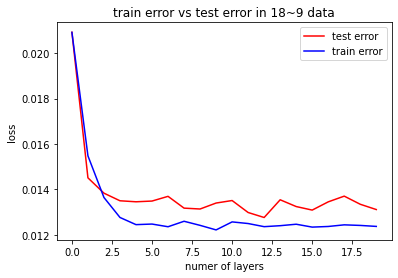

In [ ]:
# plot
n = np.arange(0,max_layer)
plt.plot(n,y_arr,c = 'red', label ='test error') 

plt.plot(n,x_arr,c = 'blue', label = 'train error')
plt.xlabel('numer of layers')
plt.ylabel('loss')
plt.title('train error vs test error in 18~9 data')
plt.savefig('train error vs test error in 18~9')
plt.legend()

In [73]:
#
for train, test in skf.split(x,y_cat): 
  model = Sequential()
  model.add(Dense(8,input_dim = 7, activation= 'relu'))
  model.add(Dense(12,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])

Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.0540 - val_loss: 0.0346
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0170
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 7/300
28/28 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 9/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 10/300
28/28 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 11/

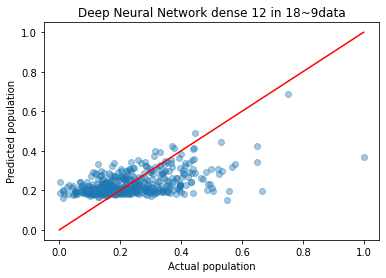

In [74]:
# plot

# about last fold
# y_predict = model.predict(x[test])

# about all data
y_predict = model.predict(x) 

import matplotlib.pyplot as plt
# about last fold
# plt.scatter(y[test], y_predict, alpha=0.4)

# about all data
plt.scatter(y, y_predict, alpha=0.4)

plt.plot([0,1],[0,1], c = 'red')
plt.xlabel("Actual population")
plt.ylabel("Predicted population")
plt.title("Deep Neural Network dense 12 in 18~9data")
plt.savefig('DNN_test_18~9.png')
plt.show() 

In [64]:
list_y = y.tolist()
list_predicty = []

for i in range(len(list_y)):
    list_predicty.append(y_predict[i].item())
diff = []
for i in range(len(list_y)):
    diff.append(list_y[i] - list_predicty[i])
diff

[-0.007310084841931852,
 0.07137573461130803,
 0.1388188128630924,
 -0.10033969838498177,
 -0.24283126660281296,
 0.15412028716744441,
 -0.0446800289199194,
 -0.0934440634443178,
 -0.21392914620457548,
 0.08026741823584821,
 0.036644046359238014,
 0.20787050725134942,
 0.12532995018944337,
 0.026528204387290866,
 -0.05063147675850527,
 -0.13773581765238374,
 0.0011034411523666854,
 -0.06895427985865998,
 -0.09138618922959432,
 -0.07310196598089855,
 0.0021831749657105215,
 -0.06802526323647837,
 -0.016687565653559444,
 -0.05825716762880112,
 0.173145004086524,
 0.23429870153023152,
 0.08090454634867844,
 0.1047790523590097,
 0.06650286256070459,
 -0.083506759296122,
 -0.18224914606828505,
 -0.07448996878210673,
 0.12575414071722352,
 -0.07622848491318723,
 -0.040431692473074626,
 0.059846045978301454,
 0.05140679488257954,
 0.07507596612308753,
 0.027414680489155185,
 -0.011809838258386773,
 -0.016548652673432446,
 -0.03499657365849923,
 -0.07295724168566245,
 -0.10558474059509079,
 0.

In [65]:
df1['diff'] = diff

In [66]:
df1.head()

,dong,highway,ffnc,fsnc,fsc,affnc,afsnc,afsc,population,pop_cat,diff
0,가락1동,0.0,0.225806,0.164634,0.000000,0.077419,0.047561,0.022764,0.299870,3.0,-0.007310
1,가락2동,0.0,0.161290,0.024390,0.016260,0.038710,0.056098,0.043902,0.303859,4.0,0.071376
2,가락본동,0.0,0.032258,0.146341,0.154472,0.045161,0.040244,0.040650,0.426756,5.0,0.138819
3,가리봉동,0.0,0.032258,0.006098,0.000000,0.283871,0.293902,0.034146,0.105551,2.0,-0.100340
4,가산동,0.0,1.000000,1.000000,0.065041,0.335484,0.343902,0.058537,0.549815,5.0,-0.242831


In [67]:
a = df1['diff'].sort_values()

In [68]:
df1_sort = df1.sort_values(by = df1.columns[-1], ascending= False )

In [69]:
df1_sort

,dong,highway,ffnc,fsnc,fsc,affnc,afsnc,afsc,population,pop_cat,diff
278,역삼1동,0.0,0.129032,0.103659,0.211382,0.058065,0.060976,0.167480,1.000000,5.0,0.702667
187,서교동,0.0,0.000000,0.006098,0.073171,0.032258,0.017073,0.048780,0.666805,5.0,0.460853
408,화곡1동,0.0,0.032258,0.000000,0.048780,0.064516,0.010976,0.066667,0.556467,5.0,0.346854
261,신촌동,0.0,0.000000,0.079268,0.000000,0.012903,0.032927,0.029268,0.500452,5.0,0.290259
280,역촌동,0.0,0.032258,0.006098,0.032520,0.006452,0.017073,0.050407,0.485855,5.0,0.289155
...,...,...,...,...,...,...,...,...,...,...,...
90,둔촌1동,0.5,0.000000,0.000000,0.000000,0.077419,0.012195,0.016260,0.002422,1.0,-0.200631
169,삼청동,0.0,0.064516,0.000000,0.000000,0.109677,0.084146,0.000000,0.002769,1.0,-0.209921
8,가회동,0.0,0.129032,0.000000,0.000000,0.109677,0.084146,0.004878,0.013113,1.0,-0.213929
108,명동,0.0,0.741935,0.018293,0.000000,0.238710,0.040244,0.026016,0.183680,2.0,-0.219565


In [70]:
df1_sort.to_excel('sort_1829df.xlsx')